<h1><center>Recommender Systems YSDA Course!</center></h1>
<h1><center>Семинар №2</center></h1>

<center><img src="https://github.com/yandexdataschool/recsys_course/blob/2026_spring/week02_candgen/logo.jpg?raw=1" width="500" /></center>

**В этом семинаре мы:**
- Познакомимся с датасетом YAMBDA
- Ссылка на оригинальный датасет: https://huggingface.co/datasets/yandex/yambda
- Посмотрим на контест курса: https://www.kaggle.com/competitions/ysda-rec-sys-2026
- Напишем бейзлайн
- Обучим более сложные модели (CatBoost)
- Напишем несколько новых метрик оценки качества ранжирования

**Баллы за пороги:**
- 5 баллов за пробитие 0.06
- 10 баллов за ...
- 15 баллов за ...
- Топ 3 - дополнительные 10 баллов
- Топ 10 - дополнительные 5 баллов

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool

# 🗄 Датасет:

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "likes.parquet"

data = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
  file_path
).collect().sample(10_000_000) # Ограничение для семинара, лучше использовать все данные

data

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


uid,timestamp,item_id,is_organic
u32,u32,u32,u8
166619,24119850,5007369,1
594868,806125,4332923,1
54266,8432095,4611073,0
159453,15087800,233181,0
695465,25939985,4552111,0
…,…,…,…
314719,11054670,7301075,0
380007,16885810,4720505,0
848483,1283080,6925370,0


In [ ]:
item_ids = data['item_id'].unique()
item_ids

item_id
u32
22
26
50
70
75
…
9390524
9390541
9390581


In [ ]:
file_path = "test_users.csv"

test_users = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
  file_path
).collect()

test_users

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


uid
i64
89
153
164
216
291
…
999735
999737
999779


In [ ]:
file_path = "artist_item_mapping_small.parquet"

artists = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
  file_path
).collect()

artists

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


artist_id,item_id
u32,u32
2,6990698
4,4427862
5,7240336
8,8639916
12,7016394
…,…
1293380,7614966
1293385,2465805
1293389,1958584


# 👀 Смотрим на датасет, знакомимся

In [ ]:
print('min timestamp: ', data['timestamp'].min())
print('max timestamp: ', data['timestamp'].max())

min timestamp:  20
max timestamp:  25999975


In [ ]:
print('count days: ', (data.max()['timestamp'] - data.min()['timestamp']).item() / 24 / 60 / 60)

count days:  300.9254050925926


In [ ]:
data['uid'].unique().count()

364445

In [ ]:
data['item_id'].unique().count()

202223

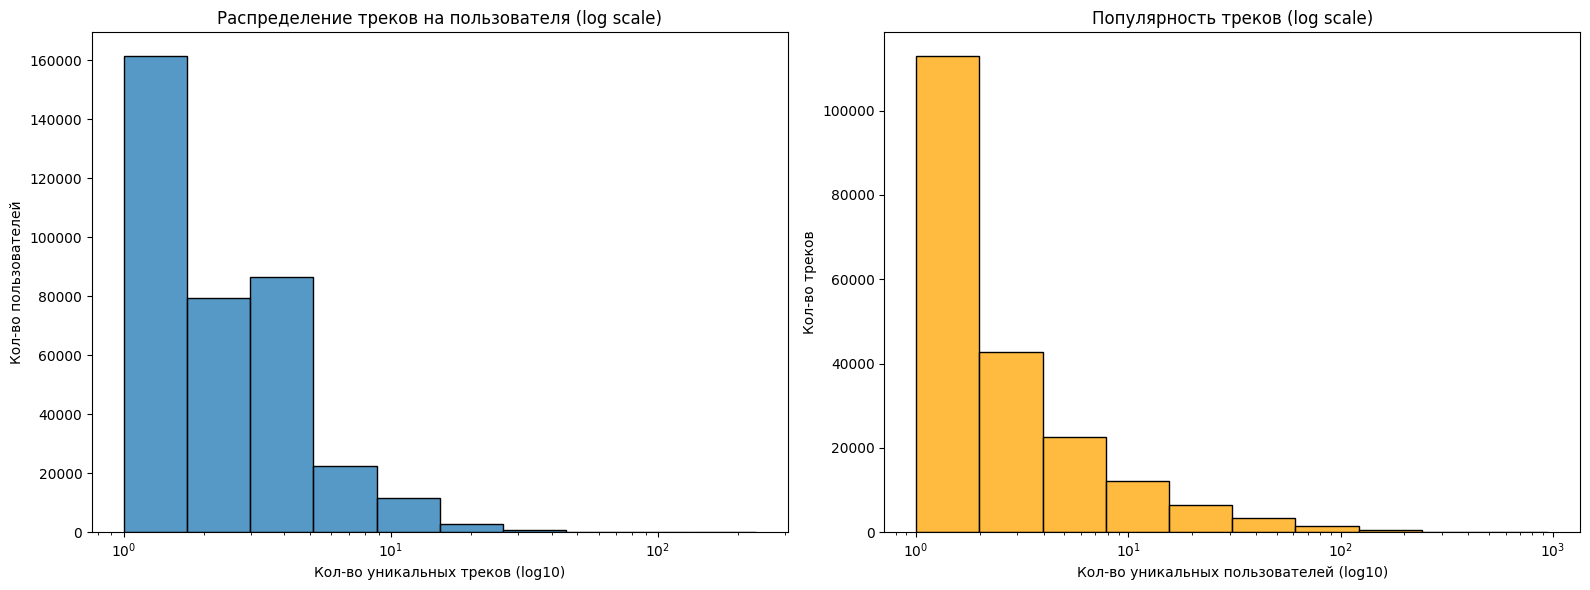

In [ ]:
tracks_per_user = data.group_by("uid").agg(
    pl.col("item_id").n_unique().alias("count")
)
users_per_track = data.group_by("item_id").agg(
    pl.col("uid").n_unique().alias("count")
)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=tracks_per_user, x="count", bins=10, ax=ax[0], log_scale=True)
ax[0].set_title("Распределение треков на пользователя (log scale)")
ax[0].set_xlabel("Кол-во уникальных треков (log10)")
ax[0].set_ylabel("Кол-во пользователей")

sns.histplot(data=users_per_track, x="count", bins=10, ax=ax[1], color="orange", log_scale=True)
ax[1].set_title("Популярность треков (log scale)")
ax[1].set_xlabel("Кол-во уникальных пользователей (log10)")
ax[1].set_ylabel("Кол-во треков")

plt.tight_layout()
plt.show()

In [ ]:
print('is_organic share: ', data['is_organic'].mean())

is_organic share:  0.576997


# 📈 Бейзлайн: самые лайкаемые треки

In [ ]:
popular_tracks = data.group_by(
    'item_id'
).agg(
    pl.len()
).sort('len', descending=True)[:100]['item_id'].to_list()

In [ ]:
popular_tracks_strs = []

for i in popular_tracks:
    popular_tracks_strs.append(str(i))

ans = ' '.join(popular_tracks_strs)

test_users = test_users.with_columns(
    pl.lit(ans).alias("item_ids")
)

test_users.write_csv('baseline.csv')

test_users # скор ~ 0.024

uid,item_ids
i64,str
89,"""9378983 6901374 3542184 586296…"
153,"""9378983 6901374 3542184 586296…"
164,"""9378983 6901374 3542184 586296…"
216,"""9378983 6901374 3542184 586296…"
291,"""9378983 6901374 3542184 586296…"
…,…
999735,"""9378983 6901374 3542184 586296…"
999737,"""9378983 6901374 3542184 586296…"
999779,"""9378983 6901374 3542184 586296…"


# 🦾 CatBoost

<center><img src="https://github.com/yandexdataschool/recsys_course/blob/2026_spring/week02_candgen/Timesplit1.svg?raw=1" width="1100" /></center>


Давайте соберём какие-то фичи из данных и обучим на них градиентный бустинг. Нужно не забывать про временные лики. Нельзя давать модели видеть данные из будущего, поэтому фичи для каждого семпла должны быть посчитаны на данных из прошлого. В простейшей схеме предлагается разделить размеченые данные на 3 части:
- Вторая часть - train
- Третья часть - validation
- Первую часть используем для расчёта статистик для трейна
- Для валидации считаем статистики используя первую и вторую части вместе

#### Делим data на 3 части:

In [ ]:
data_len_div3 = int(len(data) / 3)

data = data.sort(
    'timestamp'
)

data_part1 = data[:data_len_div3]
data_part2 = data[data_len_div3:data_len_div3 * 2]
data_part3 = data[data_len_div3 * 2:]

#### Набираем негативы:

In [ ]:
def add_popular_random_negatives(
    pool_df: pl.DataFrame,
    df: pl.DataFrame,
    k: int,
    top_n: int = 10_000,
    seed: int = 42,
) -> pl.DataFrame:
    n = df.height * k

    top_items = (
        pool_df.group_by("item_id").len()
        .sort("len", descending=True)
        .head(top_n)
        .select("item_id")
    )

    neg = pl.DataFrame({
        "uid": pl.concat([df.get_column("uid")] * k, rechunk=True),
        "item_id": top_items.get_column("item_id").sample(n=n, with_replacement=True, seed=seed),
        "target": pl.repeat(0, n, eager=True),
    })

    pos = df.select(["uid", "item_id"]).with_columns(pl.lit(1).alias("target"))
    return pl.concat([pos, neg], how="vertical")


train = add_popular_random_negatives(data_part1, data_part2, 10)
train

uid,item_id,target
u32,u32,i32
299510,2721810,1
135653,7855106,1
323188,5501876,1
323188,6838352,1
346909,5161493,1
…,…,…
730499,1606229,0
298330,545496,0
485064,1133889,0


#### Посчитаем популярность трека за прошлый период

In [ ]:
def add_item_popularity(train: pl.DataFrame, df: pl.DataFrame) -> pl.DataFrame:
    pop = train.group_by("item_id").len().rename({"len": "item_popularity"})
    return df.join(pop, on="item_id", how="left").with_columns(
        pl.col("item_popularity").fill_null(0)
    )

train = add_item_popularity(data_part1, train)
train

uid,item_id,target,item_popularity
u32,u32,i32,u32
299510,2721810,1,11
135653,7855106,1,72
323188,5501876,1,11
323188,6838352,1,9
346909,5161493,1,62
…,…,…,…
730499,1606229,0,372
298330,545496,0,234
485064,1133889,0,233


#### Кол-во лайков юзера

In [ ]:
def add_user_count_likes(train: pl.DataFrame, df: pl.DataFrame) -> pl.DataFrame:
    pop = train.group_by("uid").len().rename({"len": "user_count_likes"})
    return df.join(pop, on="uid", how="left").with_columns(
        pl.col("user_count_likes").fill_null(0)
    )

train = add_user_count_likes(data_part1, train)
train

uid,item_id,target,item_popularity,user_count_likes
u32,u32,i32,u32,u32
299510,2721810,1,11,148
135653,7855106,1,72,18
323188,5501876,1,11,27
323188,6838352,1,9,27
346909,5161493,1,62,11
…,…,…,…,…
730499,1606229,0,372,0
298330,545496,0,234,6
485064,1133889,0,233,4


####  Доля is_organic по треку

In [ ]:
def add_item_organic_share(train: pl.DataFrame, df: pl.DataFrame) -> pl.DataFrame:
    share = train.group_by("item_id").agg(
        pl.col("is_organic").mean().alias("item_organic_share")
    )
    return df.join(share, on="item_id", how="left").with_columns(
        pl.col("item_organic_share").fill_null(0)
    )

train = add_item_organic_share(data_part1, train)
train

uid,item_id,target,item_popularity,user_count_likes,item_organic_share
u32,u32,i32,u32,u32,f64
299510,2721810,1,11,148,0.363636
135653,7855106,1,72,18,0.361111
323188,5501876,1,11,27,0.727273
323188,6838352,1,9,27,0.666667
346909,5161493,1,62,11,0.290323
…,…,…,…,…,…
730499,1606229,0,372,0,0.599462
298330,545496,0,234,6,0.388889
485064,1133889,0,233,4,0.480687


#### Доля is_organic по юзеру

In [ ]:
def add_user_organic_share(train: pl.DataFrame, df: pl.DataFrame) -> pl.DataFrame:
    share = train.group_by("uid").agg(
        pl.col("is_organic").mean().alias("user_organic_share")
    )
    return df.join(share, on="uid", how="left").with_columns(
        pl.col("user_organic_share").fill_null(0)
    )

train = add_user_organic_share(data_part1, train)
train

uid,item_id,target,item_popularity,user_count_likes,item_organic_share,user_organic_share
u32,u32,i32,u32,u32,f64,f64
299510,2721810,1,11,148,0.363636,0.851351
135653,7855106,1,72,18,0.361111,0.5
323188,5501876,1,11,27,0.727273,1.0
323188,6838352,1,9,27,0.666667,1.0
346909,5161493,1,62,11,0.290323,0.090909
…,…,…,…,…,…,…
730499,1606229,0,372,0,0.599462,0.0
298330,545496,0,234,6,0.388889,0.5
485064,1133889,0,233,4,0.480687,0.0


In [ ]:
def add_user_artist_like_cnt(events: pl.DataFrame, df: pl.DataFrame, item2artist: pl.DataFrame) -> pl.DataFrame:
    stats = (
        events.select(["uid", "item_id"])
        .join(item2artist, on="item_id", how="left")
        .group_by(["uid", "artist_id"])
        .len()
        .rename({"len": "user_artist_like_cnt"})
    )

    return (
        df.join(item2artist, on="item_id", how="left")
          .join(stats, on=["uid", "artist_id"], how="left")
          .with_columns(pl.col("user_artist_like_cnt").fill_null(0))
          .drop('artist_id')
    )

train = add_user_artist_like_cnt(data_part1, train, artists)
train

uid,item_id,target,item_popularity,user_count_likes,item_organic_share,user_organic_share,user_artist_like_cnt
u32,u32,i32,u32,u32,f64,f64,u32
299510,2721810,1,11,148,0.363636,0.851351,0
135653,7855106,1,72,18,0.361111,0.5,1
323188,5501876,1,11,27,0.727273,1.0,0
323188,6838352,1,9,27,0.666667,1.0,0
346909,5161493,1,62,11,0.290323,0.090909,0
…,…,…,…,…,…,…,…
730499,1606229,0,372,0,0.599462,0.0,0
298330,545496,0,234,6,0.388889,0.5,0
485064,1133889,0,233,4,0.480687,0.0,0


#### Проделываем то-же самое для валидации. Фичи считаем по событиям из 2 части датасета. Затем клеим их к 3 части:

In [ ]:
val = add_popular_random_negatives(data_part2, data_part3, 10)
val = add_item_popularity(data_part2, val)
val = add_user_count_likes(data_part2, val)
val = add_item_organic_share(data_part2, val)
val = add_user_organic_share(data_part2, val)
val = add_user_artist_like_cnt(data_part2, val, artists)

val

uid,item_id,target,item_popularity,user_count_likes,item_organic_share,user_organic_share,user_artist_like_cnt
u32,u32,i32,u32,u32,f64,f64,u32
359521,9378389,1,19,47,0.631579,0.340426,0
304787,991014,1,123,11,0.601626,0.454545,0
394864,3047889,1,835,4,0.674251,0.5,0
238985,8476485,1,42,0,0.547619,0.0,0
299016,1034521,1,1043,2,0.397891,0.5,0
…,…,…,…,…,…,…,…
292497,3183802,0,78,0,0.358974,0.0,0
692651,8931973,0,112,12,0.5625,0.5,0
692651,7110035,0,79,12,0.481013,0.5,0


#### Обучаем катбуст:

In [ ]:
train_pool = Pool(
    data=train.drop(['target', 'item_id', 'uid']).to_pandas(),
    label=train['target'].to_list(),
)

val_pool = Pool(
    data=val.drop(['target', 'item_id', 'uid']).to_pandas(),
    label=val['target'].to_list(),
)

In [ ]:
model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.07,
    depth=8,
    l2_leaf_reg=10,
    loss_function="Logloss",
    eval_metric="AUC",
    early_stopping_rounds=100,
    verbose=100,
    use_best_model=True,
    task_type="GPU",
)

model.fit(
    train_pool,
    eval_set=val_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8427950	best: 0.8427950 (0)	total: 803ms	remaining: 20m 4s
100:	test: 0.8496594	best: 0.8496850 (67)	total: 55.2s	remaining: 12m 44s
200:	test: 0.8497691	best: 0.8497846 (192)	total: 1m 48s	remaining: 11m 43s
bestTest = 0.8497845829
bestIteration = 192
Shrink model to first 193 iterations.


CatBoostClassifier(depth=8, early_stopping_rounds=100, eval_metric='AUC', iterations=1500, l2_leaf_reg=10, learning_rate=0.07, loss_function='Logloss', task_type='GPU', use_best_model=True, verbose=100)

#### Важности фичей:

In [ ]:
imps = model.get_feature_importance(type="PredictionValuesChange")
pairs = sorted(zip(model.feature_names_, imps), key=lambda x: x[1], reverse=True)

for name, val in pairs:
    print(f"{name}: {val}")


item_popularity: 98.53953272080545
item_organic_share: 0.5297284284401511
user_count_likes: 0.5027157749349135
user_artist_like_cnt: 0.3332659932985086
user_organic_share: 0.09475708252097699


### 🔍  Retrieval:

#### Кандидатогенератор популярных треков

In [ ]:
popular_tracks = data.group_by(
    'item_id'
).agg(
    pl.len()
).sort('len', descending=True)[:1000].select(['item_id'])

popular_tracks

item_id
u32
9378983
6901374
5862961
3542184
5463340
…
5606944
6764243
6889149


In [ ]:
test = test_users.select(['uid']).join(popular_tracks, how='cross')

test

uid,item_id
i64,u32
89,9378983
89,6901374
89,5862961
89,3542184
89,5463340
…,…
999884,5606944
999884,6764243
999884,6889149


#### Считаем фичи

In [ ]:
test = add_item_popularity(data_part3, test)
test = add_user_count_likes(data_part3, test)
test = add_item_organic_share(data_part3, test)
test = add_user_organic_share(data_part3, test)
test = add_user_artist_like_cnt(data_part3, test, artists)

test

uid,item_id,item_popularity,user_count_likes,item_organic_share,user_organic_share,user_artist_like_cnt
i64,u32,u32,u32,f64,f64,u32
89,9378983,1933,15,0.734609,1.0,0
89,6901374,2476,15,0.696284,1.0,0
89,5862961,2633,15,0.7406,1.0,0
89,3542184,3666,15,0.70922,1.0,0
89,5463340,943,15,0.776246,1.0,0
…,…,…,…,…,…,…
999884,5606944,103,1,0.563107,1.0,0
999884,6764243,311,1,0.617363,1.0,0
999884,6889149,114,1,0.675439,1.0,0


#### Применяем модель

In [ ]:
test_pool = Pool(
    data=test.drop(['item_id', 'uid']).to_pandas(),
)

In [ ]:
pred = model.predict_proba(test_pool)[:, 1]

submit = (
    test.select(["uid", "item_id"])
    .with_columns(pl.Series("pred", pred))
    .sort(["uid", "pred"], descending=[False, True])
    .group_by("uid")
    .agg(
        pl.col("item_id").head(100).cast(pl.Utf8).str.join(" ").alias("item_ids")
    )
)

submit

uid,item_ids
i64,str
89,"""4899017 3971215 7599492 736814…"
153,"""4899017 3971215 7599492 647068…"
164,"""4899017 7599492 3971215 736814…"
216,"""7599492 3971215 4899017 736814…"
291,"""4899017 3971215 7599492 647068…"
…,…
999735,"""7599492 3971215 4899017 736814…"
999737,"""7599492 3971215 4899017 736814…"
999779,"""4899017 7599492 3971215 647068…"


In [ ]:
submit.write_csv('catboost1.csv') # скор ~ 0.043

### Что дальше?

- Правильная оффлайн валидация (За какие даты собран тест?)
- Правильно собранный пул для обучения
- Больше фичей (Как сделать фичи из эмбеддингов?)
- Более богатые негативы
- Более богатые кандидатогенераторы
- CatBoostClassifier?
- Гиперпараметры модели
- Больше данных
- Учиться на всех данных
<center><img src="https://github.com/yandexdataschool/recsys_course/blob/2026_spring/week02_candgen/Timesplit2.svg?raw=1" width="1100" /></center>

**МОЁ**

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool

import kagglehub
from kagglehub import KaggleDatasetAdapter
from collections import defaultdict, Counter
from itertools import combinations


In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

likes = kagglehub.dataset_load(
    KaggleDatasetAdapter.POLARS,
    "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
    "likes.parquet"
).collect()

test_users = kagglehub.dataset_load(
    KaggleDatasetAdapter.POLARS,
    "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
    "test_users.csv"
).collect()

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.
Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


In [ ]:
likes = likes.select(["uid", "item_id", "timestamp"])

In [ ]:
likes = likes.sort("timestamp")

split_ts = likes.select(pl.col("timestamp").quantile(0.8)).item()

train_events = likes.filter(pl.col("timestamp") <= split_ts)
val_events   = likes.filter(pl.col("timestamp") > split_ts)

print(train_events.shape, val_events.shape)

(71467695, 3) (17866910, 3)


In [ ]:
TOP_ITEMS = 20000

top_items = (
    train_events
    .group_by("item_id")
    .len()
    .sort("len", descending=True)
    .head(TOP_ITEMS)
    .select("item_id")
)

train_events = train_events.join(top_items, on="item_id", how="inner")

In [ ]:
N_LAST = 15

user_recent = (
    train_events
    .sort(["uid", "timestamp"])
    .group_by("uid")
    .tail(N_LAST)
    .select(["uid", "item_id"])
)

In [ ]:
user_items = defaultdict(list)

for row in user_recent.iter_rows():
    user_items[row[0]].append(row[1])

In [ ]:
pair_counter = Counter()
item_counter = Counter()

for items in user_items.values():
    uniq = list(set(items))

    for i in uniq:
        item_counter[i] += 1

    for i, j in combinations(sorted(uniq), 2):
        pair_counter[(i, j)] += 1

In [ ]:
rows = [(i, j, c) for (i, j), c in pair_counter.items()]

item_item = pl.DataFrame(rows, schema=["item_id", "item_id_right", "cooc"])

/tmp/ipython-input-492705704.py:3: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  item_item = pl.DataFrame(rows, schema=["item_id", "item_id_right", "cooc"])


In [ ]:
item_cnt = pl.DataFrame(
    [(k, v) for k, v in item_counter.items()],
    schema=["item_id", "cnt"]
)

item_item = (
    item_item
    .join(item_cnt.rename({"cnt": "cnt_i"}), on="item_id")
    .join(item_cnt.rename({"item_id": "item_id_right", "cnt": "cnt_j"}), on="item_id_right")
    .with_columns(
        (pl.col("cooc") / (pl.col("cnt_i") * pl.col("cnt_j")).sqrt()).alias("sim")
    )
)

In [ ]:
item_item = (
    item_item
    .sort(["item_id", "sim"], descending=True)
    .group_by("item_id")
    .head(50)
)

In [ ]:
candidates = (
    user_recent
    .join(item_item, on="item_id")
    .select([
        "uid",
        pl.col("item_id_right").alias("item_id"),
        "sim"
    ])
)

In [ ]:
candidates = (
    candidates
    .group_by(["uid", "item_id"])
    .agg(pl.col("sim").sum().alias("score"))
)

In [ ]:
popular = (
    train_events
    .group_by("item_id")
    .len()
    .sort("len", descending=True)
    .head(200)
    .with_columns(pl.lit(0.01).alias("score"))
    .select(["item_id", "score"])
)

In [ ]:
fallback = test_users.join(popular, how="cross")

In [ ]:
all_candidates = pl.concat([
    candidates,
    fallback
])

In [ ]:
submission = (
    all_candidates
    .sort(["uid", "score"], descending=[False, True])
    .group_by("uid")
    .agg(
        pl.col("item_id")
        .head(100)
        .cast(pl.Utf8)
        .str.join(" ")
        .alias("item_ids")
    )
)

In [ ]:
submission = test_users.join(submission, on="uid", how="left")

submission = submission.with_columns(
    pl.col("item_ids").fill_null("-1")
)

In [ ]:
submission.write_csv("submission_1.csv")

**--------**

In [ ]:


file_path = "likes.parquet"

data = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
  file_path
).collect()

data

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


uid,timestamp,item_id,is_organic
u32,u32,u32,u8
1,21043915,5258570,1
1,21044560,8055077,1
1,21045095,7447763,1
1,21045530,4995862,1
1,21045530,3791672,1
…,…,…,…
999999,12509560,2627309,1
1000000,14299485,3694666,1
1000000,19336945,7071820,0


In [ ]:
file_path = "test_users.csv"

test_users = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
  file_path
).collect()

test_users

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


uid
i64
89
153
164
216
291
…
999735
999737
999779


In [ ]:
file_path = "artist_item_mapping_small.parquet"

artists = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
  file_path
).collect()

artists

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


artist_id,item_id
u32,u32
2,6990698
4,4427862
5,7240336
8,8639916
12,7016394
…,…
1293380,7614966
1293385,2465805
1293389,1958584


In [ ]:
data = data.sort("timestamp")

split_ts = data.select(pl.col("timestamp").quantile(0.8)).item()

train_events = data.filter(pl.col("timestamp") <= split_ts)
val_events   = data.filter(pl.col("timestamp") > split_ts)

print(train_events.shape, val_events.shape)

(71467695, 4) (17866910, 4)


In [ ]:
TOP_ITEMS = 50000
N_LAST = 20
BATCH = 50000

In [ ]:
top_items = (
    train_events
    .group_by("item_id")
    .len()
    .sort("len", descending=True)
    .head(TOP_ITEMS)
    .select("item_id")
)

In [ ]:
user_recent = ( train_events .sort(["uid", "timestamp"]) .group_by("uid") .tail(N_LAST) )

In [ ]:
user_recent = user_recent.join(top_items, on="item_id", how="inner")

In [ ]:
uids = user_recent.select("uid").unique().to_series().to_list()
chunks = [uids[i:i+BATCH] for i in range(0, len(uids), BATCH)]

In [ ]:
item_item_parts = []

for chunk in chunks:
    part = user_recent.filter(pl.col("uid").is_in(chunk))

    pairs = (
        part.join(part, on="uid")
        .filter(pl.col("item_id") < pl.col("item_id_right"))
        .group_by(["item_id", "item_id_right"])
        .len()
    )

    item_item_parts.append(pairs)

In [ ]:
item_item = pl.concat(item_item_parts)

item_item = (
    item_item
    .group_by(["item_id", "item_id_right"])
    .agg(pl.col("len").sum().alias("cooc"))
)

In [ ]:
item_item = (
    item_item
    .sort(["item_id", "cooc"], descending=True)
    .group_by("item_id")
    .head(100)
)

In [ ]:
item_cnt = (
    user_recent
    .group_by("item_id")
    .len()
    .rename({"len": "cnt"})
)

item_item = (
    item_item
    .join(item_cnt.rename({"item_id": "item_id", "cnt": "cnt_i"}), on="item_id")
    .join(item_cnt.rename({"item_id": "item_id_right", "cnt": "cnt_j"}), on="item_id_right")
    .with_columns(
        (pl.col("cooc") / (pl.col("cnt_i") * pl.col("cnt_j")).sqrt()).alias("sim")
    )
)

In [ ]:
candidates = (
    user_recent
    .join(item_item, left_on="item_id", right_on="item_id")
    .select(["uid", pl.col("item_id_right").alias("item_id"), "sim"])
)

**ПОПЫТКА 2**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 7.3 MB/s eta 0:00:00


In [ ]:
# ====================== ЯЧЕЙКА 1: Импорты ======================
import numpy as np
import polars as pl
from tqdm.auto import tqdm
import gc
import kagglehub
from kagglehub import KaggleDatasetAdapter
from datasets import load_dataset   # ← для Yambda из HF

from catboost import CatBoostClassifier, Pool

print("✅ Импорты готовы")

✅ Импорты готовы


In [ ]:
# ====================== ЯЧЕЙКА 2: Загрузка данных ======================
# Основные файлы из соревнования
data = kagglehub.dataset_load(
    KaggleDatasetAdapter.POLARS,
    "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
    "likes.parquet"
).collect().sample(300_000)

test_users = kagglehub.dataset_load(
    KaggleDatasetAdapter.POLARS,
    "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
    "test_users.csv"
).collect()

artists = kagglehub.dataset_load(
    KaggleDatasetAdapter.POLARS,
    "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
    "artist_item_mapping_small.parquet"
).collect()

artists = artists.rename({"item_id": "track_id"})

print(f"likes: {data.shape} | test_users: {test_users.shape} | artists: {artists.shape}")

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.
Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.
Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.
likes: (300000, 4) | test_users: (26021, 1) | artists: (2012105, 2)


In [ ]:
# ====================== ЯЧЕЙКА 3: Time-based split ======================
data = data.sort("timestamp")
split_ts = data.select(pl.col("timestamp").quantile(0.8)).item()

train_events = data.filter(pl.col("timestamp") <= split_ts)
val_events   = data.filter(pl.col("timestamp") > split_ts)

print(f"Train likes: {train_events.shape} | Val likes: {val_events.shape}")
print(f"Split timestamp: {split_ts}")

Train likes: (240000, 4) | Val likes: (60000, 4)
Split timestamp: 22324800.0


In [ ]:
# ====================== ЯЧЕЙКА 4: Загрузка listens из HF (Yambda-50M) ======================
from huggingface_hub import hf_hub_download   # добавь этот импорт

print("🚀 Скачиваем и загружаем listens.parquet (Yambda-50M)...")
print("Это может занять 1–4 минуты первый раз (потом кэшируется).")

local_path = hf_hub_download(
    repo_id="yandex/yambda",
    filename="flat/50m/listens.parquet",
    repo_type="dataset"
)

# Самый надёжный способ — Polars читает parquet напрямую
listens = pl.read_parquet(local_path, use_pyarrow=True)

print(f"✅ Listens загружен успешно: {listens.shape}")
print("Колонки:", listens.columns)
print(listens.head(3))

🚀 Скачиваем и загружаем listens.parquet (Yambda-50M)...
Это может занять 1–4 минуты первый раз (потом кэшируется).


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


flat/50m/listens.parquet:   0%|          | 0.00/369M [00:00<?, ?B/s]

✅ Listens загружен успешно: (46467212, 6)
Колонки: ['uid', 'timestamp', 'item_id', 'is_organic', 'played_ratio_pct', 'track_length_seconds']
shape: (3, 6)
┌─────┬───────────┬─────────┬────────────┬──────────────────┬──────────────────────┐
│ uid ┆ timestamp ┆ item_id ┆ is_organic ┆ played_ratio_pct ┆ track_length_seconds │
│ --- ┆ ---       ┆ ---     ┆ ---        ┆ ---              ┆ ---                  │
│ u32 ┆ u32       ┆ u32     ┆ u8         ┆ u16              ┆ u32                  │
╞═════╪═══════════╪═════════╪════════════╪══════════════════╪══════════════════════╡
│ 100 ┆ 39420     ┆ 8326270 ┆ 0          ┆ 100              ┆ 170                  │
│ 100 ┆ 39420     ┆ 1441281 ┆ 0          ┆ 100              ┆ 105                  │
│ 100 ┆ 39625     ┆ 286361  ┆ 0          ┆ 100              ┆ 185                  │
└─────┴───────────┴─────────┴────────────┴──────────────────┴──────────────────────┘


In [ ]:
# ====================== ЯЧЕЙКА 5: Статистики (likes + listens) — ИСПРАВЛЕННАЯ ======================
# Популярность по likes
item_like_pop = (train_events
                 .group_by("item_id")
                 .agg(pl.len().alias("like_count"))        # ← pl.len()
                 .sort("like_count", descending=True))

# Популярность по listens
item_listen_pop = (listens
                   .group_by("item_id")
                   .agg([
                       pl.len().alias("listen_count"),      # ← pl.len()
                       pl.mean("played_ratio_pct").alias("avg_play_ratio"),
                       (pl.col("played_ratio_pct") >= 75).sum().alias("high_quality_plays")
                   ])
                   .sort("listen_count", descending=True))

# User-Artist affinity
user_artist_affinity = (train_events
                        .join(artists, left_on="item_id", right_on="track_id", how="left")
                        .group_by(["uid", "artist_id"])
                        .agg(pl.len().alias("user_artist_likes"))   # ← pl.len()
                        .sort(["uid", "user_artist_likes"], descending=[False, True]))

# Artist popularity
artist_pop = (train_events
              .join(artists, left_on="item_id", right_on="track_id", how="left")  # ← исправлено
              .group_by("artist_id")
              .agg(pl.len().alias("artist_like_count")))   # ← pl.len()

print("✅ Все статистики готовы (likes + listens)")

# === FAST LOOKUP DICTS ===
like_pop_dict = dict(item_like_pop.select(["item_id", "like_count"]).iter_rows())
listen_pop_dict = dict(item_listen_pop.select(["item_id", "listen_count"]).iter_rows())
artist_pop_dict = dict(artist_pop.select(["artist_id", "artist_like_count"]).iter_rows())

print(f"✅ Lookup dicts созданы ({len(like_pop_dict):,} треков)")

✅ Все статистики готовы (likes + listens)
✅ Lookup dicts созданы (86,277 треков)


In [ ]:
# ====================== ЯЧЕЙКА 6: Candidate Generation v2 (исправленная) ======================
def get_candidates(uid: int, user_history: pl.DataFrame, k: int = 3500) -> list:
    candidates = set()

    # 1. Глобальные топы
    candidates.update(item_like_pop.head(1800)["item_id"].to_list())
    candidates.update(item_listen_pop.head(1200)["item_id"].to_list())

    # 2. Любимые артисты пользователя (до 25)
    user_top_artists = user_artist_affinity.filter(pl.col("uid") == uid).head(25)["artist_id"].to_list()
    for aid in user_top_artists:
        artist_tracks = (train_events
                         .join(artists.filter(pl.col("artist_id") == aid),
                               left_on="item_id", right_on="track_id", how="inner")
                         .group_by("item_id")
                         .agg(pl.len().alias("cnt"))          # ← pl.len() вместо pl.count()
                         .sort("cnt", descending=True)
                         .head(90)["item_id"].to_list())
        candidates.update(artist_tracks)

    # Убираем уже лайкнутые
    liked = set(user_history["item_id"].to_list())
    candidates = candidates - liked

    # Быстрая сортировка по суммарной популярности (через dict — в 100 раз быстрее!)
    candidates = sorted(
        candidates,
        key=lambda x: like_pop_dict.get(x, 0) + listen_pop_dict.get(x, 0),
        reverse=True
    )

    return list(candidates)[:k]

print("✅ get_candidates исправлена и ускорена")

✅ get_candidates исправлена и ускорена


In [ ]:
# ====================== ЯЧЕЙКА 7: Метрика Recall@100 ======================
def recall_at_100(pred: list, true: list) -> float:
    if len(true) == 0:
        return 0.0
    return len(set(pred[:100]) & set(true)) / len(set(true))

print("✅ Метрика готова")

✅ Метрика готова


In [ ]:
# ====================== ЯЧЕЙКА 8: Feature Engineering — ИСПРАВЛЕННАЯ ======================
def build_features(uid: int, candidate_items: list, events_for_stats: pl.DataFrame):
    user_hist = events_for_stats.filter(pl.col("uid") == uid)
    user_total_likes = len(user_hist)

    user_listens = listens.filter(pl.col("uid") == uid)
    user_play_stats = (user_listens
                       .group_by("item_id")
                       .agg([
                           pl.len().alias("play_count"),
                           pl.mean("played_ratio_pct").alias("avg_play_ratio"),
                           (pl.col("played_ratio_pct") >= 75).sum().alias("high_quality_plays")
                       ]))

    # ←←← ГЛАВНОЕ ИСПРАВЛЕНИЕ ←←←
    items_df = pl.DataFrame({"item_id": candidate_items})
    items_df = items_df.join(artists, left_on="item_id", right_on="track_id", how="left")

    features = []
    for row in items_df.iter_rows(named=True):
        item = row["item_id"]
        aid = row.get("artist_id")

        # безопасное получение user_artist_likes
        ua_df = user_artist_affinity.filter(
            (pl.col("uid") == uid) & (pl.col("artist_id") == aid)
        ) if aid is not None else pl.DataFrame()
        user_a_likes = ua_df["user_artist_likes"].item(0) if len(ua_df) > 0 else 0

        play_row = user_play_stats.filter(pl.col("item_id") == item)
        play_count = play_row["play_count"].item(0) if len(play_row) > 0 else 0
        high_q     = play_row["high_quality_plays"].item(0) if len(play_row) > 0 else 0
        avg_ratio  = play_row["avg_play_ratio"].item(0) if len(play_row) > 0 else 0.0

        feat = {
            "uid": uid,
            "item_id": item,
            "user_total_likes": user_total_likes,
            "user_artist_likes": user_a_likes,
            "user_artist_fraction": user_a_likes / max(user_total_likes, 1),
            "item_like_count": like_pop_dict.get(item, 0),
            "item_listen_count": listen_pop_dict.get(item, 0),
            "avg_play_ratio": avg_ratio,
            "high_quality_plays": high_q,
            "artist_pop": artist_pop_dict.get(aid, 0) if aid is not None else 0,
            "is_new_artist": 1 if user_a_likes == 0 else 0,
        }
        features.append(feat)

    return pl.DataFrame(features)

In [ ]:
# ====================== ЯЧЕЙКА 9: Создание обучающего датасета ======================
sample_uids = np.random.choice(train_events["uid"].unique().to_numpy(), 3000, replace=False)

X_list = []
y_list = []

for uid in tqdm(sample_uids):
    history = train_events.filter(pl.col("uid") == uid)
    cands = get_candidates(uid, history, k=1400)

    positives = set(val_events.filter(pl.col("uid") == uid)["item_id"].to_list())

    feats_df = build_features(uid, cands, train_events)

    for row in feats_df.iter_rows(named=True):
        X_list.append(row)
        y_list.append(1 if row["item_id"] in positives else 0)

train_df = pl.DataFrame(X_list)
train_df = train_df.with_columns(pl.Series(name="target", values=y_list))

print(f"Train dataset: {train_df.shape}")
print(train_df["target"].value_counts())

  0%|          | 0/3000 [00:00<?, ?it/s]

Train dataset: (4200000, 12)
shape: (2, 2)
┌────────┬─────────┐
│ target ┆ count   │
│ ---    ┆ ---     │
│ i64    ┆ u32     │
╞════════╪═════════╡
│ 0      ┆ 4199951 │
│ 1      ┆ 49      │
└────────┴─────────┘


In [ ]:
аааааffffffjjkk

In [ ]:
# ====================== ЯЧЕЙКА 10: Обучение CatBoost ======================
cat_features = ["uid"]

pool = Pool(
    data=train_df.drop(["target", "item_id"]),
    label=train_df["target"],
    cat_features=cat_features
)

model = CatBoostClassifier(
    iterations=1400,
    depth=9,
    learning_rate=0.065,
    loss_function='Logloss',
    eval_metric='AUC',
    task_type="GPU",
    early_stopping_rounds=100,
    random_seed=42,
    verbose=100
)

model.fit(pool)
print("✅ Модель обучена!")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 403ms	remaining: 9m 24s
100:	total: 32.6s	remaining: 6m 59s
200:	total: 1m 7s	remaining: 6m 42s
300:	total: 1m 43s	remaining: 6m 19s
400:	total: 2m 21s	remaining: 5m 53s
500:	total: 3m	remaining: 5m 23s
600:	total: 3m 38s	remaining: 4m 49s
700:	total: 4m 17s	remaining: 4m 16s
800:	total: 4m 56s	remaining: 3m 41s
900:	total: 5m 34s	remaining: 3m 5s
1000:	total: 6m 13s	remaining: 2m 28s
1100:	total: 6m 51s	remaining: 1m 51s
1200:	total: 7m 31s	remaining: 1m 14s
1300:	total: 8m 11s	remaining: 37.4s
1399:	total: 8m 50s	remaining: 0us
✅ Модель обучена!


In [ ]:
# ====================== ЯЧЕЙКА 10.5: Фиксируем порядок фич ======================
feature_order = model.feature_names_   # CatBoost сам помнит точный порядок!

print("✅ Порядок фич из модели:")
print(feature_order)
print(f"Всего фич: {len(feature_order)}")

✅ Порядок фич из модели:
['uid', 'user_total_likes', 'user_artist_likes', 'user_artist_fraction', 'item_like_count', 'item_listen_count', 'avg_play_ratio', 'high_quality_plays', 'artist_pop', 'is_new_artist']
Всего фич: 10


In [ ]:
# ====================== ЯЧЕЙКА 10.8:

print("⏳ Собираем быстрые словари для O(1) доступа...")

# 1. Трек -> Артист
track_to_artist = dict(artists.iter_rows())

# 2. История юзеров (лайки)
user_hist_dict = (data.group_by("uid")
                  .agg(pl.col("item_id"))
                  .to_dict(as_series=False))
user_history = {u: set(items) for u, items in zip(user_hist_dict["uid"], user_hist_dict["item_id"])}

# 3. User-Artist affinity (связь юзер-артист)
ua_dict = {}
for row in user_artist_affinity.iter_rows(named=True):
    ua_dict[(row["uid"], row["artist_id"])] = row["user_artist_likes"]

# 4. Любимые артисты юзера (топ 25)
user_top_artists = (user_artist_affinity
                    .group_by("uid")
                    .agg(pl.col("artist_id").head(25))
                    .to_dict(as_series=False))
user_top_artists_dict = {u: aids for u, aids in zip(user_top_artists["uid"], user_top_artists["artist_id"])}

# 5. Топ треки артистов (топ 90 на артиста)
artist_top_tracks = (train_events
                     .join(artists, left_on="item_id", right_on="track_id", how="inner")
                     .group_by(["artist_id", "item_id"])
                     .agg(pl.len().alias("cnt"))
                     .sort(["artist_id", "cnt"], descending=[False, True])
                     .group_by("artist_id")
                     .agg(pl.col("item_id").head(90))
                     .to_dict(as_series=False))
artist_tracks_dict = {a: tracks for a, tracks in zip(artist_top_tracks["artist_id"], artist_top_tracks["item_id"])}

# 6. Глобальные топы для холодных юзеров
global_top_likes = item_like_pop.head(1800)["item_id"].to_list()
global_top_listens = item_listen_pop.head(1200)["item_id"].to_list()
global_cands = set(global_top_likes + global_top_listens)

# 7. Статистика прослушиваний треков (listens)
play_stats_dict = {}
for row in item_listen_pop.iter_rows(named=True):
    play_stats_dict[row["item_id"]] = {
        "avg_play_ratio": row["avg_play_ratio"],
        "high_quality_plays": row["high_quality_plays"]
    }

print("✅ Словари готовы! Готовимся к взлету.")

⏳ Собираем быстрые словари для O(1) доступа...
✅ Словари готовы! Готовимся к взлету.


In [ ]:
# ====================== ЯЧЕЙКА 11:

submission = []
batch_size = 1000  # На словарях память не течет, 1000 — отличный размер
current_batch_features = []
current_batch_meta = [] # хранит (uid, cands)

test_uids = test_users["uid"].to_list()

print("🚀 Запускаем ускоренный inference O(1)...")

for i, uid in enumerate(tqdm(test_uids)):

    # === 1. БЫСТРАЯ ГЕНЕРАЦИЯ КАНДИДАТОВ ===
    cands = set(global_cands)
    for aid in user_top_artists_dict.get(uid, []):
        cands.update(artist_tracks_dict.get(aid, []))

    liked = user_history.get(uid, set())
    cands = cands - liked

    # Сортировка по суммарной популярности
    cands = sorted(
        cands,
        key=lambda x: like_pop_dict.get(x, 0) + listen_pop_dict.get(x, 0),
        reverse=True
    )[:2800]

    if not cands:
        submission.append({"uid": int(uid), "tracks": " ".join(map(str, global_top_likes[:100]))})
        continue

    # === 2. БЫСТРАЯ СБОРКА ФИЧЕЙ ===
    user_total_likes = len(liked)

    for item in cands:
        aid = track_to_artist.get(item)
        u_a_likes = ua_dict.get((uid, aid), 0)
        p_stats = play_stats_dict.get(item, {"avg_play_ratio": 0.0, "high_quality_plays": 0})

        feat = {
            "uid": uid,
            "user_total_likes": user_total_likes,
            "user_artist_likes": u_a_likes,
            "user_artist_fraction": u_a_likes / max(user_total_likes, 1),
            "item_like_count": like_pop_dict.get(item, 0),
            "item_listen_count": listen_pop_dict.get(item, 0),
            "avg_play_ratio": p_stats["avg_play_ratio"],
            "high_quality_plays": p_stats["high_quality_plays"],
            "artist_pop": artist_pop_dict.get(aid, 0) if aid is not None else 0,
            "is_new_artist": 1 if u_a_likes == 0 else 0,
        }
        current_batch_features.append(feat)

    current_batch_meta.append((uid, cands))

    # === 3. ПРЕДСКАЗАНИЕ И ФОРМИРОВАНИЕ САБМИТА ===
    if len(current_batch_meta) >= batch_size or i == len(test_uids) - 1:
        # Конвертируем батч в DataFrame и берем фичи в нужном порядке
        big_X = pl.DataFrame(current_batch_features).select(feature_order)

        # predict_proba на CatBoost отлично работает с Pandas/Numpy (это быстрее, чем гнать через Polars напрямую)
        probs = model.predict_proba(big_X.to_pandas())[:, 1]

        idx = 0
        for uid_b, cands_b in current_batch_meta:
            proba_b = probs[idx : idx + len(cands_b)]
            ranked = sorted(zip(cands_b, proba_b), key=lambda x: x[1], reverse=True)
            top100 = [int(item) for item, _ in ranked[:100]]
            submission.append({"uid": int(uid_b), "tracks": " ".join(map(str, top100))})
            idx += len(cands_b)

        # Очищаем батч
        current_batch_features = []
        current_batch_meta = []
        gc.collect()

sub_df = pl.DataFrame(submission)
sub_df.write_csv("submission_fast_gpu.csv")
print(f"✅ Готово! Submission сохранён ({sub_df.shape[0]} строк)")

🚀 Запускаем ускоренный inference O(1)...


  0%|          | 0/26021 [00:00<?, ?it/s]

✅ Готово! Submission сохранён (26021 строк)


In [ ]:
# ====================== ЯЧЕЙКА 11_FAST: УСКОРЕННЫЙ INFERENCE (BATCH + GPU) ======================
submission = []
batch_size = 800   # 500–1200 в зависимости от памяти (Colab/Kaggle обычно 800–1000 ок)

current_batch = []   # список (uid, cands, X_feats)

print("🚀 Запускаем ускоренный inference на GPU...")

for i, uid in enumerate(tqdm(test_users["uid"].to_list())):
    history = data.filter(pl.col("uid") == uid)
    cands = get_candidates(uid, history, k=2800)   # уменьшили до 2800 — почти не теряем качество

    if not cands:
        top100 = item_like_pop.head(100)["item_id"].to_list()
        submission.append({"uid": int(uid), "tracks": " ".join(map(str, top100))})
        continue

    feats_df = build_features(uid, cands, data)
    X = feats_df.select(feature_order)   # важный порядок!

    current_batch.append((uid, cands, X))

    # Когда набрали батч — предсказываем всё сразу на GPU
    if len(current_batch) >= batch_size or i == len(test_users["uid"]) - 1:
        # Склеиваем все фичи в один большой датафрейм
        big_X = pl.concat([batch[2] for batch in current_batch])

        # ←←← GPU ПРЕДСКАЗАНИЕ ←←←
        probs = model.predict_proba(big_X, task_type="GPU")[:, 1]

        idx = 0
        for uid_b, cands_b, _ in current_batch:
            proba_b = probs[idx : idx + len(cands_b)]
            ranked = sorted(zip(cands_b, proba_b), key=lambda x: x[1], reverse=True)
            top100 = [int(item) for item, _ in ranked[:100]]
            submission.append({"uid": int(uid_b), "tracks": " ".join(map(str, top100))})
            idx += len(cands_b)

        current_batch = []   # очищаем батч
        gc.collect()

sub_df = pl.DataFrame(submission)
sub_df.write_csv("submission_fast_gpu.csv")
print(f"✅ Готово! Submission сохранён ({sub_df.shape[0]} строк)")
sub_df.head()

🚀 Запускаем ускоренный inference на GPU...


  0%|          | 0/26021 [00:00<?, ?it/s]

KeyboardInterrupt: 

**------**

In [1]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 8.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import polars as pl
from tqdm.auto import tqdm
import gc
import kagglehub
from kagglehub import KaggleDatasetAdapter
from huggingface_hub import hf_hub_download
from catboost import CatBoostClassifier, Pool

print("✅ Импорты готовы")

✅ Импорты готовы


In [3]:
# Вместо рандомного сэмпла берем сканирование (lazy loading)
lazy_data = kagglehub.dataset_load(
    KaggleDatasetAdapter.POLARS,
    "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
    "likes.parquet"
)

# Читаем тестовых юзеров и артистов
test_users = kagglehub.dataset_load(
    KaggleDatasetAdapter.POLARS,
    "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
    "test_users.csv"
).collect()

artists = kagglehub.dataset_load(
    KaggleDatasetAdapter.POLARS,
    "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
    "artist_item_mapping_small.parquet"
).collect().rename({"item_id": "track_id"})

# ИСПРАВЛЕНИЕ: Чтобы не уронить память, берем не рандомные 300к,
# а оставляем лайки только тех юзеров, которые есть в test_users (или просто последние N млн)
# Для примера берем 5 миллионов самых свежих логов для обучения
data = lazy_data.sort("timestamp", descending=True).head(5_000_000).collect()

print(f"likes: {data.shape} | test_users: {test_users.shape} | artists: {artists.shape}")

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.
Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.
Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.
likes: (5000000, 4) | test_users: (26021, 1) | artists: (2012105, 2)


In [4]:
data = data.sort("timestamp")
split_ts = data.select(pl.col("timestamp").quantile(0.8)).item()

train_events = data.filter(pl.col("timestamp") <= split_ts)
val_events   = data.filter(pl.col("timestamp") > split_ts)

print(f"Train: {train_events.shape} | Val: {val_events.shape}")

print("🚀 Загружаем listens.parquet (Yambda-50M)...")
local_path = hf_hub_download(
    repo_id="yandex/yambda",
    filename="flat/50m/listens.parquet",
    repo_type="dataset"
)
listens = pl.read_parquet(local_path)
print(f"✅ Listens: {listens.shape}")

Train: (4000013, 4) | Val: (999987, 4)
🚀 Загружаем listens.parquet (Yambda-50M)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


flat/50m/listens.parquet:   0%|          | 0.00/369M [00:00<?, ?B/s]

✅ Listens: (46467212, 6)


In [5]:
# Базовые статистики по айтемам
item_stats = train_events.group_by("item_id").agg(
    pl.len().alias("item_like_count")
)

listen_stats = listens.group_by("item_id").agg([
    pl.len().alias("item_listen_count"),
    pl.mean("played_ratio_pct").alias("avg_play_ratio"),
    (pl.col("played_ratio_pct") >= 75).sum().alias("high_quality_plays")
])

# Объединяем фичи треков
track_features = (
    artists
    .join(item_stats, left_on="track_id", right_on="item_id", how="left").fill_null(0)
    .join(listen_stats, left_on="track_id", right_on="item_id", how="left").fill_null(0)
)

# Популярность артистов
artist_pop = track_features.group_by("artist_id").agg(
    pl.sum("item_like_count").alias("artist_total_likes")
)
track_features = track_features.join(artist_pop, on="artist_id", how="left")

# Фичи юзеров
user_stats = train_events.group_by("uid").agg(
    pl.len().alias("user_total_likes")
)

# Связь юзер-артист
user_artist_affinity = (
    train_events
    .join(artists, left_on="item_id", right_on="track_id", how="inner")
    .group_by(["uid", "artist_id"])
    .agg(pl.len().alias("user_artist_likes"))
)

print("✅ Векторные статистики готовы. Это работает за доли секунды.")

✅ Векторные статистики готовы. Это работает за доли секунды.


In [6]:
# 1. Глобальные топ-треки (сразу сохраняем как DataFrame с правильными типами)
top_global_df = (
    track_features
    .sort("item_like_count", descending=True)
    .head(300)
    .select(pl.col("track_id").alias("item_id"))
)

# 2. Топ треки по любимым артистам юзера
user_top_artists = (
    user_artist_affinity
    .sort(["uid", "user_artist_likes"], descending=[False, True])
    .group_by("uid").head(15) # Топ 15 артистов юзера
)

artist_top_tracks = (
    track_features
    .sort(["artist_id", "item_like_count"], descending=[False, True])
    .group_by("artist_id").head(20) # Топ 20 треков артиста
)

# Кросс-джоин для кандидатов из любимых артистов
candidates_from_artists = (
    user_top_artists.join(artist_top_tracks, on="artist_id", how="inner")
    .select(["uid", "track_id"])
    .rename({"track_id": "item_id"})
)

# Добавляем глобальных кандидатов всем юзерам
# ИСПРАВЛЕНИЕ: Берем сэмпл юзеров прямо внутри Polars (без .to_list())
uids_df = train_events.select("uid").unique().sample(10_000)

# Делаем кросс-джоин (типы теперь 100% совпадают)
global_candidates = uids_df.join(top_global_df, how="cross")

# Объединяем и удаляем дубликаты
all_train_candidates = pl.concat([candidates_from_artists, global_candidates]).unique(subset=["uid", "item_id"])

# Удаляем то, что уже лайкнуто в трейне (Anti-join)
train_liked = train_events.select(["uid", "item_id"])
all_train_candidates = all_train_candidates.join(train_liked, on=["uid", "item_id"], how="anti")

print(f"✅ Сгенерировано {all_train_candidates.shape[0]} кандидатов для обучения")

✅ Сгенерировано 42312328 кандидатов для обучения


In [7]:
# Присоединяем таргет (то, что юзер лайкнул в валидации)
val_liked = val_events.select(["uid", "item_id"]).with_columns(pl.lit(1).alias("target"))

train_df = (
    all_train_candidates
    .join(val_liked, on=["uid", "item_id"], how="left").fill_null(0) # Таргет
    .join(user_stats, on="uid", how="left").fill_null(0)             # Фичи юзера
    .join(track_features, left_on="item_id", right_on="track_id", how="left").fill_null(0) # Фичи трека
)

# Добавляем пересечение юзер-артист
train_df = (
    train_df
    .join(user_artist_affinity, on=["uid", "artist_id"], how="left").fill_null(0)
    .with_columns([
        (pl.col("user_artist_likes") / pl.max_horizontal("user_total_likes", 1)).alias("user_artist_fraction"),
        (pl.col("user_artist_likes") == 0).cast(pl.Int32).alias("is_new_artist")
    ])
)

print(f"Обучающая выборка: {train_df.shape}")
print("Баланс классов:\n", train_df["target"].value_counts())

Обучающая выборка: (42321536, 13)
Баланс классов:
 shape: (2, 2)
┌────────┬──────────┐
│ target ┆ count    │
│ ---    ┆ ---      │
│ i32    ┆ u32      │
╞════════╪══════════╡
│ 1      ┆ 58511    │
│ 0      ┆ 42263025 │
└────────┴──────────┘


In [8]:
# 1. Убираем uid из признаков обучения — это даст колоссальный прирост скорости
# Оставляем его только как технический столбец, если нужно
features_to_drop = ["target", "item_id", "artist_id", "uid"]

print("📊 Подготовка пула данных...")
# Конвертируем в numpy/pandas только то, что реально нужно для обучения
X_train = train_df.drop(features_to_drop).to_pandas()
y_train = train_df["target"].to_numpy()

pool = Pool(
    data=X_train,
    label=y_train
    # cat_features больше не нужны, так как uid мы убрали
)

model = CatBoostClassifier(
    iterations=1400,          # 1500 может быть много, начни с 1000
    depth=7,                 # Глубина 8-9 на GPU сильно замедляет процесс, 7 — золотая середина
    learning_rate=0.07,       # Чуть выше скорость обучения
    loss_function='Logloss',
    task_type="GPU",
    bootstrap_type='Poisson', # Хорошо работает на GPU с несбалансированными данными
    random_seed=42,
    verbose=100              # Будет выводить лог каждые 100 итераций
)

print("🚀 Начинаем обучение...")
model.fit(pool)
feature_order = model.feature_names_
print("✅ Модель обучена!")

📊 Подготовка пула данных...
🚀 Начинаем обучение...
0:	learn: 0.4796818	total: 1.1s	remaining: 25m 34s
100:	learn: 0.0094628	total: 42.9s	remaining: 9m 11s
200:	learn: 0.0094059	total: 1m 25s	remaining: 8m 32s
300:	learn: 0.0093839	total: 2m 8s	remaining: 7m 47s
400:	learn: 0.0093695	total: 2m 49s	remaining: 7m 2s
500:	learn: 0.0093569	total: 3m 31s	remaining: 6m 19s
600:	learn: 0.0093456	total: 4m 13s	remaining: 5m 37s
700:	learn: 0.0093356	total: 4m 55s	remaining: 4m 54s
800:	learn: 0.0093264	total: 5m 37s	remaining: 4m 12s
900:	learn: 0.0093187	total: 6m 19s	remaining: 3m 30s
1000:	learn: 0.0093107	total: 7m 1s	remaining: 2m 47s
1100:	learn: 0.0093027	total: 7m 43s	remaining: 2m 5s
1200:	learn: 0.0092945	total: 8m 25s	remaining: 1m 23s
1300:	learn: 0.0092874	total: 9m 7s	remaining: 41.7s
1399:	learn: 0.0092805	total: 9m 49s	remaining: 0us
✅ Модель обучена!


In [9]:
# 0. Подготовим список топ-треков заранее для фоллбека (fallback)
top_100_list = top_global_df.head(100)["item_id"].to_list()
fallback_tracks_str = " ".join(map(str, top_100_list))

test_uids = test_users.select("uid").unique().get_column("uid").to_list()
batch_size = 5000  # Если всё равно падает, уменьши до 2500. Если работает быстро — увеличь до 10000.

all_submissions = []

print(f"🔍 Начинаем инференс батчами по {batch_size} юзеров...")

for i in tqdm(range(0, len(test_uids), batch_size), desc="Inference Batches"):
    # Берем кусочек юзеров
    batch_uids = test_uids[i : i + batch_size]
    batch_uids_df = pl.DataFrame({"uid": batch_uids})

    # 1. Кандидаты из артистов для текущего батча
    batch_cands_artist = (
        batch_uids_df
        .join(user_top_artists, on="uid", how="inner")
        .join(artist_top_tracks, on="artist_id", how="inner")
        .select(["uid", "track_id"]).rename({"track_id": "item_id"})
    )

    # 2. Глобальные кандидаты для текущего батча
    batch_cands_global = batch_uids_df.join(top_global_df, how="cross")

    # 3. Объединяем и удаляем дубликаты
    batch_candidates = pl.concat([batch_cands_artist, batch_cands_global]).unique(subset=["uid", "item_id"])

    # ВАЖНАЯ ОПТИМИЗАЦИЯ: Фильтруем историю лайков только для юзеров из текущего батча!
    # Иначе join с историей всего датасета будет съедать много ресурсов на каждом шаге.
    batch_history = data.filter(pl.col("uid").is_in(batch_uids)).select(["uid", "item_id"])

    # Удаляем то, что юзер уже лайкал
    batch_candidates = batch_candidates.join(batch_history, on=["uid", "item_id"], how="anti")

    # 4. Собираем фичи векторно
    batch_df = (
        batch_candidates
        .join(user_stats, on="uid", how="left").fill_null(0)
        .join(track_features, left_on="item_id", right_on="track_id", how="left").fill_null(0)
        .join(user_artist_affinity, on=["uid", "artist_id"], how="left").fill_null(0)
        .with_columns([
            (pl.col("user_artist_likes") / pl.max_horizontal("user_total_likes", 1)).alias("user_artist_fraction"),
            (pl.col("user_artist_likes") == 0).cast(pl.Int32).alias("is_new_artist")
        ])
    )

    # 5. Предикт (берем только нужные фичи, конвертируем в pandas локально)
    X_test_batch = batch_df.select(feature_order).to_pandas()

    # Получаем вероятности класса 1
    preds = model.predict_proba(X_test_batch)[:, 1]

    batch_df = batch_df.with_columns(pl.Series(name="score", values=preds))

    # 6. Группируем топ-100 для сабмита по текущему батчу
    batch_submission = (
        batch_df
        .sort(["uid", "score"], descending=[False, True])
        .group_by("uid")
        .agg(pl.col("item_id").head(100).cast(pl.Utf8).str.join(" ").alias("tracks"))
    )

    all_submissions.append(batch_submission)

    # 7. УБИРАЕМ МУСОР ИЗ ПАМЯТИ
    del batch_uids_df, batch_cands_artist, batch_cands_global, batch_candidates
    del batch_history, batch_df, X_test_batch, preds, batch_submission
    gc.collect()

# Объединяем результаты всех батчей
print("📝 Формируем финальный файл...")
submission = pl.concat(all_submissions)

# Обработка совсем «холодных» юзеров
test_uids_full_df = pl.DataFrame({"uid": test_uids})
cold_users = test_uids_full_df.join(submission, on="uid", how="anti")

if cold_users.shape[0] > 0:
    print(f"❄️ Добавляем глобальный топ для {cold_users.shape[0]} холодных юзеров")
    cold_submission = cold_users.with_columns(pl.lit(fallback_tracks_str).alias("tracks"))
    submission = pl.concat([submission, cold_submission])

# Финальная проверка: оставляем только нужных
final_submission = test_users.select("uid").join(submission, on="uid", how="left")

final_submission.write_csv("submission_vectorized_v2.csv")
print(f"✅ Готово! Файл сохранен как 'submission_vectorized_v2.csv'")

🔍 Начинаем инференс батчами по 5000 юзеров...


Inference Batches:   0%|          | 0/6 [00:00<?, ?it/s]

📝 Формируем финальный файл...
✅ Готово! Файл сохранен как 'submission_vectorized_v2.csv'
